# **1000-719bMSB Modeling of Complex Biological Systems**
# **Deep Neural Network: Unsupervised Learning**

# Variational Autoencoder on MNIST

VAEs are directed probabilistic graphical models (DPGM) whose posterior is approximated by a neural network, forming an autoencoder-like architecture. Unlike discriminative modeling that aims to learn a predictor given observation, generative modeling tries to learn how the data is generated, and to reflect the underlying causal relations. [...] Variational autoencoder models make strong assumptions concerning the distribution of latent variables. They use a variational approach for latent representation learning, which results in an additional loss component and a specific estimator for the training algorithm called the Stochastic Gradient Variational Bayes (SGVB) estimator. [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

We build a VAE and train it on the MNIST dataset.  

In [4]:
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np


img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

2.4.1


In [5]:
#Define encoder network
#Note that we are using keras functional API
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
#x = layers.Dense(2, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [6]:
#Sampling from the distributions to obtain latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)

In [7]:
#Define decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [8]:
def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [9]:
vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

In [10]:
vae.summary()
decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [11]:
#load the data and split into train + test sets
(x_train, _), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [12]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [83]:
print(x_train)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.

We are ready to train VAE on this dataset 

In [13]:
vae.fit(x=x_train,y=x_train, shuffle=True, epochs=10, batch_size=batch_size)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 157s 3ms/sample - loss: 0.2172
Epoch 2/10
60000/60000 [==============================] - 158s 3ms/sample - loss: 0.1961
Epoch 3/10
60000/60000 [==============================] - 153s 3ms/sample - loss: 0.1908
Epoch 4/10
60000/60000 [==============================] - 155s 3ms/sample - loss: 0.1874
Epoch 5/10
60000/60000 [==============================] - 157s 3ms/sample - loss: 0.1852
Epoch 6/10
60000/60000 [==============================] - 160s 3ms/sample - loss: 0.1835
Epoch 7/10
60000/60000 [==============================] - 157s 3ms/sample - loss: 0.1822
Epoch 8/10
60000/60000 [==============================] - 164s 3ms/sample - loss: 0.1813
Epoch 9/10
60000/60000 [==============================] - 166s 3ms/sample - loss: 0.1803
Epoch 10/10
60000/60000 [==============================] - 169s 3ms/sample - loss: 0.1795


In [14]:
# to save the trained VAE on Google Drive and load them later. Not necessary
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#vae.save_weights('drive/My Drive/Colab Notebooks/vae_weights.h5')
vae.load_weights('drive/My Drive/Colab Notebooks/vae_weights.h5')

In [15]:
# x_test is data
# encoded: means we are mapping our data point (x_test) into latent space; give us a point in latent space
encoded = encoder.predict(x_test)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [19]:
print(encoded)

[[ 0.5011592   0.7988604 ]
 [ 1.8056308  -3.090244  ]
 [ 1.0460266   3.2783914 ]
 ...
 [ 0.35356754  0.94176126]
 [-2.483836    0.547221  ]
 [-0.6149318  -0.40848416]]


[0.5011592 0.7988604]


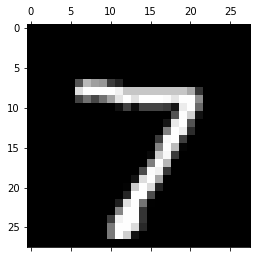

In [20]:
print(encoded[0])
plt.matshow(x_test[0][:,:,0], cmap='gray')

[ 1.8056308 -3.090244 ]


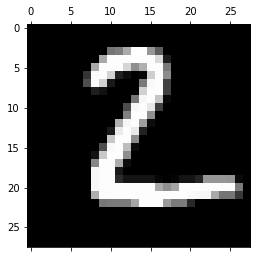

In [21]:
print(encoded[1])
plt.matshow(x_test[1][:,:,0], cmap='gray')

In [59]:
# decoded: reconstructing
decoded = decoder.predict(encoded)
decoded_some_random = decoder.predict(encoded)

ValueError: Error when checking input: expected input_2 to have shape (2,) but got array with shape (1,)

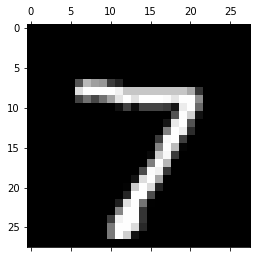

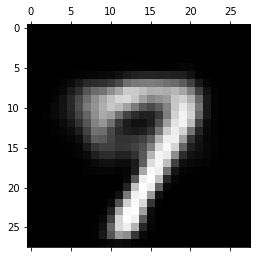

In [24]:
plt.matshow(x_test[0][:,:,0], cmap='gray')
plt.matshow(decoded[0][:,:,0], cmap='gray')

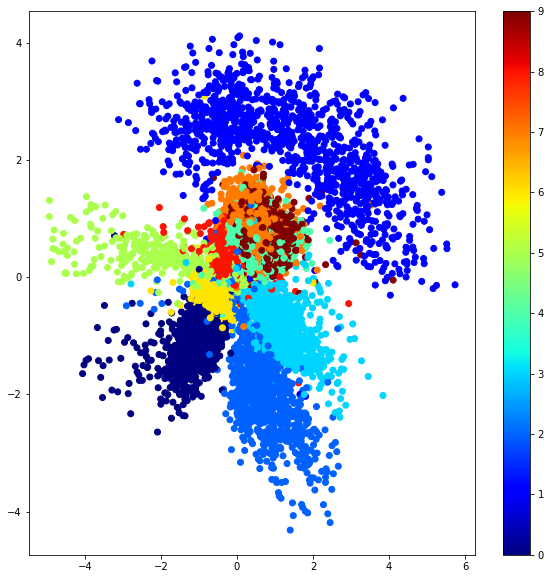

In [25]:
x_test_encoded = encoder.predict(x_test)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

**HOMEWORK 1** 

Interpolate between two latent vectors (i.e., moving in the latent space) and decode and visualize the interpolations. Provide a code (python notebook) to do this interpolation; and provide 3 interpolated images in-between.

(array([0.5011592, 0.8272771, 1.153395 , 1.4795129, 1.8056308]),
 array([ 0.7988604, -0.1734157, -1.1456918, -2.1179679, -3.090244 ]))

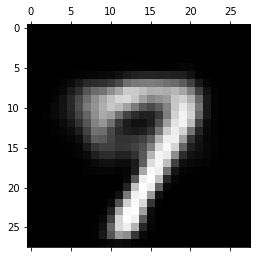

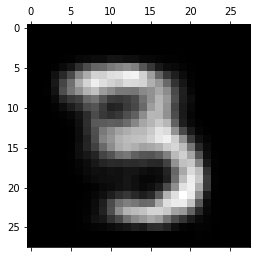

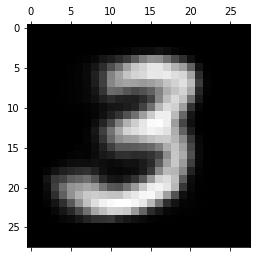

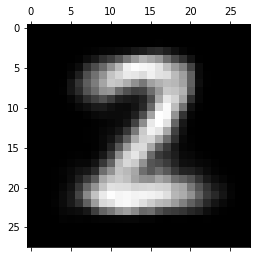

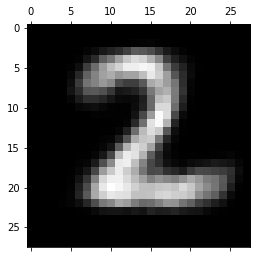

In [82]:
# plt.matshow(x_test[0][:,:,0], cmap='gray')
# just use linspace between two values, decode them and plot 3 of them in between
# easy I hope

#plt.matshow(x_test[0][:,:,0], cmap='gray')
import numpy as np

def interpolate(vector1, vector2):
    
    outputs = []
    
    x1 = vector1[0]
    y1 = vector1[1]
    x2 = vector2[0]
    y2 = vector2[1]
    xs = np.linspace(x1, x2, 5)
    ys = np.linspace(y1, y2, 5)
    
    for i in range(len(xs)):    
        decoded_ = decoder.predict([[[xs[i], ys[i]]]])      
        outputs.append(decoded_)
        plt.matshow(decoded_[0][:,:,0], cmap='gray')
        
    return xs, ys

interpolate([0.5011592, 0.7988604], [1.8056308, -3.090244])

# DeepDream

[Read the introduction to DeepDream](https://web.archive.org/web/20150703064823/http://googleresearch.blogspot.co.uk/2015/06/inceptionism-going-deeper-into-neural.html)

In [24]:
from keras.applications import inception_v3
from keras import backend as K
#disable all training-specific options
K.set_learning_phase(0)

In [25]:
model = inception_v3.InceptionV3(weights='imagenet',
include_top=False)



87916544/87910968 [==============================] - 1s 0us/step


In [26]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [27]:
#coefficients for contribution of selected layers
layer_contributions = {
'mixed2': 0.2,
'mixed3': 3.,
'mixed4': 2.,
'mixed5': 1.5,
}

In [28]:
#Creates a dictionary that maps layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [29]:
layer_dict['mixed2']

In [30]:
#define the loss
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    #here the loss is the L2 norm of activations of whole layer 
    #before: only chosen filter
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling   

In [31]:
#define gradient-ascent process

#this was before a noise image, now image of choice
dream = model.input

#gradient of loss wrt input image
grads = K.gradients(loss, dream)[0]
#normalize gradient
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values
    
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x = x + step * grad_values
    return x

In [32]:
#define some auxilliary function
import scipy
from keras.preprocessing import image
import imageio
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
    float(size[0]) / img.shape[1],
    float(size[1]) / img.shape[2],
    1)
    return scipy.ndimage.zoom(img, factors, order=1)
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(400,400))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        #undoes the preprocessing done by inception_v3.preprocess_input
        x = x.reshape((x.shape[1], x.shape[2], 3))
        x /= 2.
        x += 0.5
        x *= 255.
        x = np.clip(x, 0, 255).astype('uint8')
    return x

In [33]:
base_image_path = 'drive/My Drive/Colab Notebooks/hill_wiki.jpg'
img = preprocess_image(base_image_path)

...Loss value at 0 : 1.4439688
...Loss value at 1 : 1.9676836
...Loss value at 2 : 2.6519878
...Loss value at 3 : 3.4305315
...Loss value at 4 : 4.215274
...Loss value at 5 : 4.960674
...Loss value at 6 : 5.7233286
...Loss value at 7 : 6.4873857
...Loss value at 8 : 7.203998
...Loss value at 9 : 7.900006
...Loss value at 10 : 8.54136
...Loss value at 11 : 9.170447
...Loss value at 12 : 9.799172


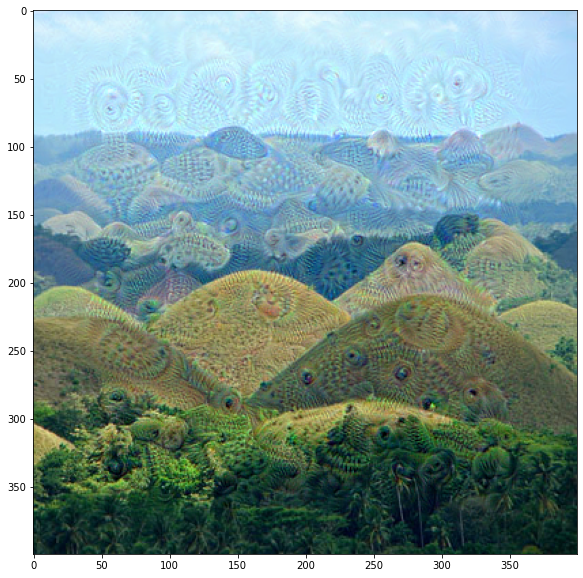

In [34]:
step = 0.01
iterations = 20
max_loss = 10.

img = gradient_ascent(img,
        iterations=iterations,
        step=step,
        max_loss=max_loss)

plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(deprocess_image(img))

In [36]:
import numpy as np
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.
base_image_path = 'drive/My Drive/Colab Notebooks/hill_wiki.jpg'
img = preprocess_image(base_image_path)

In [37]:
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
        for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [38]:
successive_shapes

[(204, 204), (285, 285), (400, 400)]

In [39]:
#to make the effect look cooler
for shape in successive_shapes:
    print('Processing image shape', shape)
    #upscale image and apply gradient descent
    img = resize_img(img, shape)
    img = gradient_ascent(img,
        iterations=iterations,
        step=step,
        max_loss=max_loss)
    
    #insert details lost by upscaling
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape) #will be pixelated
    same_size_original = resize_img(original_img, shape)                  #high-quality image by downscaling original
    lost_detail = same_size_original - upscaled_shrunk_original_img       #detail that was lost when scaling up

    img = img + lost_detail #reinsert the detail
    shrunk_original_img = resize_img(original_img, shape)

Processing image shape (204, 204)
...Loss value at 0 : 1.1689276
...Loss value at 1 : 1.5709248
...Loss value at 2 : 2.0570633
...Loss value at 3 : 2.5652423
...Loss value at 4 : 3.1711361
...Loss value at 5 : 3.7650876
...Loss value at 6 : 4.3903055
...Loss value at 7 : 4.9174166
...Loss value at 8 : 5.488883
...Loss value at 9 : 6.06728
...Loss value at 10 : 6.6517735
...Loss value at 11 : 7.1327405
...Loss value at 12 : 7.614458
...Loss value at 13 : 8.150249
...Loss value at 14 : 8.603481
...Loss value at 15 : 9.061551
...Loss value at 16 : 9.492758
...Loss value at 17 : 9.926556
Processing image shape (285, 285)
...Loss value at 0 : 2.5925894
...Loss value at 1 : 3.9572997
...Loss value at 2 : 5.0516043
...Loss value at 3 : 6.046936
...Loss value at 4 : 6.823206
...Loss value at 5 : 7.620211
...Loss value at 6 : 8.318689
...Loss value at 7 : 8.979014
...Loss value at 8 : 9.613117
Processing image shape (400, 400)
...Loss value at 0 : 2.6382694
...Loss value at 1 : 3.8557458
...Los

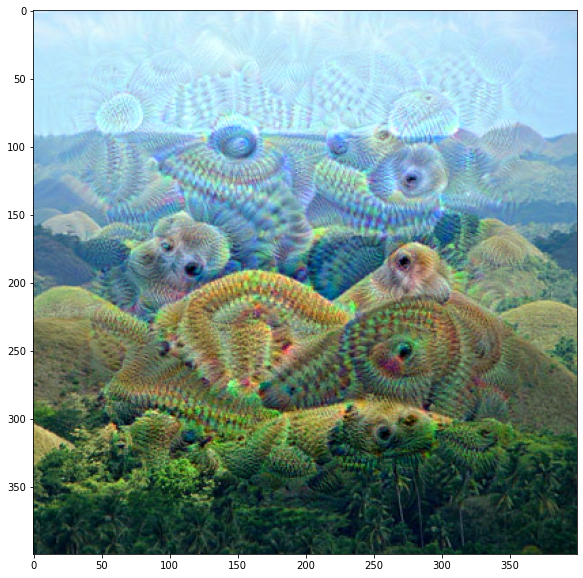

In [40]:
plt.imshow(deprocess_image(img))